
# Fine-Tuning Scheduler

* **Author:** [Dan Dale](https://github.com/speediedan)
* **License:** CC BY-SA
* **Generated:** 2023-09-26T12:14:37.204343

This notebook introduces the [Fine-Tuning Scheduler](https://finetuning-scheduler.readthedocs.io/en/stable/index.html) extension
and demonstrates the use of it to fine-tune a small foundation model on the
[RTE](https://huggingface.co/datasets/viewer/?dataset=super_glue&config=rte) task of
[SuperGLUE](https://super.gluebenchmark.com/) with iterative early-stopping defined according to a user-specified
schedule. It uses Hugging Face's ``datasets`` and ``transformers`` libraries to retrieve the relevant benchmark data
and foundation model weights. The required dependencies are installed via the finetuning-scheduler ``[examples]`` extra.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/finetuning-scheduler.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "torch>=1.12.1" "torch>=1.8.1, <2.1.0" "matplotlib>=3.0.0, <3.8.0" "urllib3" "torchmetrics>=0.7, <1.2" "setuptools>=68.0.0, <68.2.0" "finetuning-scheduler[examples]>=2.0.0" "ipython[notebook]>=8.0.0, <8.15.0" "pytorch-lightning>=1.4, <2.1.0"


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


## Scheduled Fine-Tuning with the Fine-Tuning Scheduler Extension

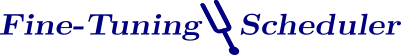{height="55px" width="401px"}

The [Fine-Tuning Scheduler](https://finetuning-scheduler.readthedocs.io/en/stable/index.html) extension accelerates and enhances model experimentation with flexible fine-tuning schedules.

Training with the extension is simple and confers a host of benefits:

- it dramatically increases fine-tuning flexibility
- expedites and facilitates exploration of model tuning dynamics
- enables marginal performance improvements of fine-tuned models

Setup is straightforward, just install from PyPI! Since this notebook-based example requires a few additional packages (e.g.
``transformers``, ``sentencepiece``), we installed the ``finetuning-scheduler`` package with the ``[examples]`` extra above.
Once the ``finetuning-scheduler`` package is installed, the [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) callback (FTS) is available for use with Lightning.
For additional installation options, please see the Fine-Tuning Scheduler [README](https://github.com/speediedan/finetuning-scheduler/blob/main/README.md).



<div style="display:inline" id="a1">

Fundamentally, [Fine-Tuning Scheduler](https://finetuning-scheduler.readthedocs.io/en/stable/index.html) enables
scheduled, multi-phase, fine-tuning of foundation models. Gradual unfreezing (i.e. thawing) can help maximize
foundation model knowledge retention while allowing (typically upper layers of) the model to
optimally adapt to new tasks during transfer learning [1, 2, 3](#f1)

</div>

The [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) callback orchestrates the gradual unfreezing
of models via a fine-tuning schedule that is either implicitly generated (the default) or explicitly provided by the user
(more computationally efficient). Fine-tuning phase transitions are driven by
[FTSEarlyStopping](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSEarlyStopping)
criteria (a multi-phase extension of ``EarlyStopping`` packaged with FinetuningScheduler), user-specified epoch transitions or a composition of the two (the default mode).
A [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) training session completes when the
final phase of the schedule has its stopping criteria met. See
the [early stopping documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.EarlyStopping.html) for more details on that callback's configuration.

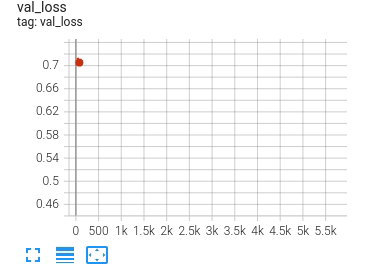{height="272px" width="376px"}


## Basic Usage

<div id="basic_usage">

If no fine-tuning schedule is provided by the user, [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) will generate a
[default schedule](#The-Default-Finetuning-Schedule) and proceed to fine-tune according to the generated schedule,
using default [FTSEarlyStopping](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSEarlyStopping) and [FTSCheckpoint](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSCheckpoint) callbacks with ``monitor=val_loss``.

</div>

```python
import lightning as L
from finetuning_scheduler import FinetuningScheduler
trainer = L.Trainer(callbacks=[FinetuningScheduler()])
```

## The Default Fine-Tuning Schedule

Schedule definition is facilitated via the [gen_ft_schedule](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.ScheduleImplMixin.gen_ft_schedule) method which dumps a default fine-tuning schedule (by default using a naive, 2-parameters per level heuristic) which can be adjusted as
desired by the user and/or subsequently passed to the callback. Using the default/implicitly generated schedule will likely be less computationally efficient than a user-defined fine-tuning schedule but is useful for exploring a model's fine-tuning behavior and can serve as a good baseline for subsequent explicit schedule refinement.
While the current version of [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) only supports single optimizer and (optional) lr_scheduler configurations, per-phase maximum learning rates can be set as demonstrated in the next section.

## Specifying a Fine-Tuning Schedule

To specify a fine-tuning schedule, it's convenient to first generate the default schedule and then alter the thawed/unfrozen parameter groups associated with each fine-tuning phase as desired. Fine-tuning phases are zero-indexed and executed in ascending order.

1. First, generate the default schedule to ``Trainer.log_dir``. It will be named after your
   ``LightningModule`` subclass with the suffix ``_ft_schedule.yaml``.

```python
    import lightning as L
    from finetuning_scheduler import FinetuningScheduler
    trainer = L.Trainer(callbacks=[FinetuningScheduler(gen_ft_sched_only=True)])
```

2. Alter the schedule as desired.

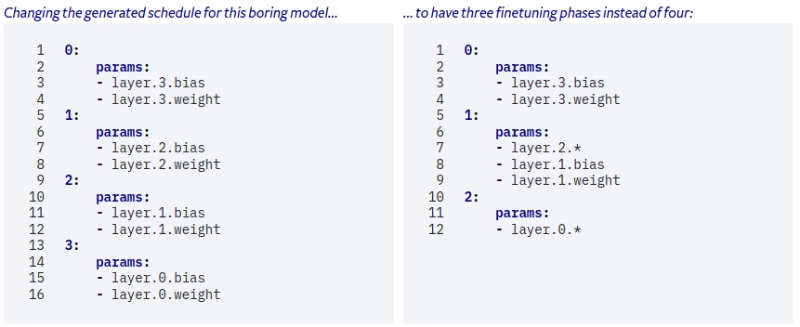{height="327px" width="800px"}

3. Once the fine-tuning schedule has been altered as desired, pass it to
   [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) to commence scheduled training:

```python
import lightning as L
from finetuning_scheduler import FinetuningScheduler

trainer = L.Trainer(callbacks=[FinetuningScheduler(ft_schedule="/path/to/my/schedule/my_schedule.yaml")])
```

## Early-Stopping and Epoch-Driven Phase Transition Criteria


By default, [FTSEarlyStopping](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSEarlyStopping) and epoch-driven
transition criteria are composed. If a ``max_transition_epoch`` is specified for a given phase, the next fine-tuning phase will begin at that epoch unless [FTSEarlyStopping](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSEarlyStopping) criteria are met first.
If [FinetuningScheduler.epoch_transitions_only](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler.params.epoch_transitions_only) is ``True``, [FTSEarlyStopping](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSEarlyStopping) will not be used
and transitions will be exclusively epoch-driven.


<div class="alert alert-info">

**Tip:** Use of regex expressions can be convenient for specifying more complex schedules. Also, a per-phase base maximum lr can be specified:

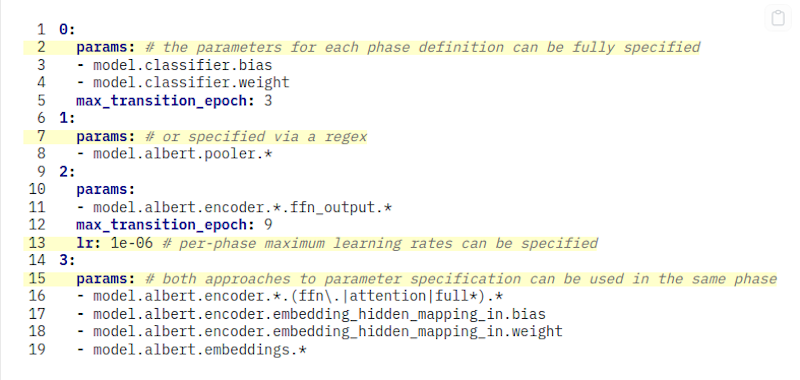{height="380px" width="800px"}

</div>



The end-to-end example in this notebook ([Scheduled Fine-Tuning For SuperGLUE](#superglue)) uses [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) in explicit mode to fine-tune a small foundation model on the [RTE](https://huggingface.co/datasets/viewer/?dataset=super_glue&config=rte) task of [SuperGLUE](https://super.gluebenchmark.com/).
Please see the [official Fine-Tuning Scheduler documentation](https://finetuning-scheduler.readthedocs.io/en/stable/index.html) if you are interested in a similar [CLI-based example](https://finetuning-scheduler.readthedocs.io/en/stable/index.html#example-scheduled-fine-tuning-for-superglue) using the LightningCLI.

## Resuming Scheduled Fine-Tuning Training Sessions

Resumption of scheduled fine-tuning training is identical to the continuation of
[other training sessions](https://lightning.ai/docs/pytorch/stable/common/trainer.html) with the caveat that the provided checkpoint must have been saved by a [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) session.
[FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) uses [FTSCheckpoint](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSCheckpoint) (an extension of ``ModelCheckpoint``) to maintain schedule state with special metadata.


```python
import lightning as L
from finetuning_scheduler import FinetuningScheduler
trainer = L.Trainer(callbacks=[FinetuningScheduler()])
trainer.ckpt_path="some/path/to/my_checkpoint.ckpt"
trainer.fit(...)
```

Training will resume at the depth/level of the provided checkpoint according to the specified schedule. Schedules can be altered between training sessions but schedule compatibility is left to the user for maximal flexibility. If executing a user-defined schedule, typically the same schedule should be provided for the original and resumed training sessions.

By default ([FinetuningScheduler.restore_best](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html?highlight=restore_best#finetuning_scheduler.fts.FinetuningScheduler.params.restore_best) is ``True``), [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) will attempt to restore the best available checkpoint before fine-tuning depth transitions.

```python
trainer = L.Trainer(callbacks=[FinetuningScheduler()])
trainer.ckpt_path="some/path/to/my_kth_best_checkpoint.ckpt"
trainer.fit(...)
```

Note that similar to the behavior of [ModelCheckpoint](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelCheckpoint.html), when resuming training with a
different [FTSCheckpoint](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSCheckpoint) ``dirpath`` from the provided
checkpoint, the new training session's checkpoint state will be re-initialized at the resumption depth with the provided checkpoint being set as the best checkpoint.

<div class="alert alert-warning">

**Note:** Currently, [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) supports the following distributed strategy types:

- ``ddp`` (and aliases ``ddp_find_unused_parameters_false``, ``ddp_find_unused_parameters_true``, ``ddp_spawn``, ``ddp_fork``, ``ddp_notebook``)
- ``fsdp`` (and alias ``fsdp_cpu_offload``)

Custom or officially unsupported strategies can be used by setting [FinetuningScheduler.allow_untested](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html?highlight=allow_untested#finetuning_scheduler.fts.FinetuningScheduler.params.allow_untested) to ``True``.
Note that most currently unsupported strategies are so because they require varying degrees of modification to be compatible. For example, ``deepspeed`` will require a [StrategyAdapter](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.strategy_adapters.html#finetuning_scheduler.strategy_adapters.StrategyAdapter) to be written (similar to the one for ``FSDP``, [FSDPStrategyAdapter](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.strategy_adapters.html#finetuning_scheduler.strategy_adapters.FSDPStrategyAdapter)) before support can be added (PRs welcome!),
while ``tpu_spawn`` would require an override of the current broadcast method to include python objects.
</div>

<div id="superglue"></div>

## Scheduled Fine-Tuning For SuperGLUE

The following example demonstrates the use of [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) to fine-tune a small foundation model on the [RTE](https://huggingface.co/datasets/viewer/?dataset=super_glue&config=rte) task of [SuperGLUE](https://super.gluebenchmark.com/). Iterative early-stopping will be applied according to a user-specified schedule.


In [2]:
import os
import warnings
from datetime import datetime
from typing import Any, Dict, Optional

import datasets
import evaluate

In [3]:
# Import the `FinetuningScheduler` PyTorch Lightning extension module we want to use. This will import all necessary callbacks.
import finetuning_scheduler as fts  # isort: split

import lightning as L
import sentencepiece as sp  # noqa: F401 # isort: split
import torch
from datasets import logging as datasets_logging
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
from lightning.pytorch.utilities import rank_zero_warn
from torch.optim.adamw import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import logging as transformers_logging
from transformers.tokenization_utils_base import BatchEncoding

# set notebook-level variables
TASK_NUM_LABELS = {"boolq": 2, "rte": 2}
DEFAULT_TASK = "rte"

# reduce hf logging verbosity to focus on tutorial-relevant code/messages
for hflogger in [transformers_logging, datasets_logging]:
    hflogger.set_verbosity_error()
# ignore warnings related tokenizers_parallelism/DataLoader parallelism trade-off and
# expected logging behavior
for warnf in [
    r".*does not have many workers.*",
    r".*The number of training samples.*",
    r".*converting to a fast.*",
    r".*number of training batches.*",
]:
    warnings.filterwarnings("ignore", warnf)

In [4]:
class RteBoolqDataModule(L.LightningDataModule):
    """A ``LightningDataModule`` designed for both the RTE or BoolQ SuperGLUE Hugging Face datasets."""

    TASK_TEXT_FIELD_MAP = {"rte": ("premise", "hypothesis"), "boolq": ("question", "passage")}
    LOADER_COLUMNS = (
        "datasets_idx",
        "input_ids",
        "token_type_ids",
        "attention_mask",
        "start_positions",
        "end_positions",
        "labels",
    )

    def __init__(
        self,
        model_name_or_path: str,
        task_name: str = DEFAULT_TASK,
        max_seq_length: int = 128,
        train_batch_size: int = 16,
        eval_batch_size: int = 16,
        tokenizers_parallelism: bool = True,
        **dataloader_kwargs: Any,
    ):
        r"""Initialize the ``LightningDataModule`` designed for both the RTE or BoolQ SuperGLUE Hugging Face
        datasets.

        Args:
            model_name_or_path (str):
                Can be either:
                    - A string, the ``model id`` of a pretrained model hosted inside a model repo on huggingface.co.
                        Valid model ids can be located at the root-level, like ``bert-base-uncased``, or namespaced
                        under a user or organization name, like ``dbmdz/bert-base-german-cased``.
                    - A path to a ``directory`` containing model weights saved using
                        :meth:`~transformers.PreTrainedModel.save_pretrained`, e.g., ``./my_model_directory/``.
            task_name (str, optional): Name of the SuperGLUE task to execute. This module supports 'rte' or 'boolq'.
                Defaults to DEFAULT_TASK which is 'rte'.
            max_seq_length (int, optional): Length to which we will pad sequences or truncate input. Defaults to 128.
            train_batch_size (int, optional): Training batch size. Defaults to 16.
            eval_batch_size (int, optional): Batch size to use for validation and testing splits. Defaults to 16.
            tokenizers_parallelism (bool, optional): Whether to use parallelism in the tokenizer. Defaults to True.
            \**dataloader_kwargs: Arguments passed when initializing the dataloader.
        """
        super().__init__()
        task_name = task_name if task_name in TASK_NUM_LABELS.keys() else DEFAULT_TASK
        self.text_fields = self.TASK_TEXT_FIELD_MAP[task_name]
        self.dataloader_kwargs = {
            "num_workers": dataloader_kwargs.get("num_workers", 0),
            "pin_memory": dataloader_kwargs.get("pin_memory", False),
        }
        self.save_hyperparameters()
        os.environ["TOKENIZERS_PARALLELISM"] = "true" if self.hparams.tokenizers_parallelism else "false"
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.hparams.model_name_or_path, use_fast=True, local_files_only=False
        )

    def prepare_data(self):
        """Load the SuperGLUE dataset."""
        # N.B. PL calls prepare_data from a single process (rank 0) so do not use it to assign
        # state (e.g. self.x=y)
        datasets.load_dataset("super_glue", self.hparams.task_name)

    def setup(self, stage):
        """Setup our dataset splits for training/validation."""
        self.dataset = datasets.load_dataset("super_glue", self.hparams.task_name)
        for split in self.dataset.keys():
            self.dataset[split] = self.dataset[split].map(
                self._convert_to_features, batched=True, remove_columns=["label"]
            )
            self.columns = [c for c in self.dataset[split].column_names if c in self.LOADER_COLUMNS]
            self.dataset[split].set_format(type="torch", columns=self.columns)

        self.eval_splits = [x for x in self.dataset.keys() if "validation" in x]

    def train_dataloader(self):
        return DataLoader(self.dataset["train"], batch_size=self.hparams.train_batch_size, **self.dataloader_kwargs)

    def val_dataloader(self):
        return DataLoader(self.dataset["validation"], batch_size=self.hparams.eval_batch_size, **self.dataloader_kwargs)

    def _convert_to_features(self, example_batch: datasets.arrow_dataset.LazyDict) -> BatchEncoding:
        """Convert raw text examples to a :class:`~transformers.tokenization_utils_base.BatchEncoding` container
        (derived from python dict) of features that includes helpful methods for translating between word/character
        space and token space.

        Args:
            example_batch ([type]): The set of examples to convert to token space.

        Returns:
            ``BatchEncoding``: A batch of encoded examples (note default tokenizer batch_size=1000).
        """
        text_pairs = list(zip(example_batch[self.text_fields[0]], example_batch[self.text_fields[1]]))
        # Tokenize the text/text pairs
        features = self.tokenizer.batch_encode_plus(
            text_pairs, max_length=self.hparams.max_seq_length, padding="longest", truncation=True
        )
        # Rename label to labels to make it easier to pass to model forward
        features["labels"] = example_batch["label"]
        return features

In [5]:
class RteBoolqModule(L.LightningModule):
    """A ``LightningModule`` that can be used to fine-tune a foundation model on either the RTE or BoolQ SuperGLUE
    tasks using Hugging Face implementations of a given model and the `SuperGLUE Hugging Face dataset."""

    def __init__(
        self,
        model_name_or_path: str,
        optimizer_init: Dict[str, Any],
        lr_scheduler_init: Dict[str, Any],
        model_cfg: Optional[Dict[str, Any]] = None,
        task_name: str = DEFAULT_TASK,
        experiment_tag: str = "default",
    ):
        """
        Args:
            model_name_or_path (str): Path to pretrained model or identifier from https://huggingface.co/models.
            optimizer_init (Dict[str, Any]): The desired optimizer configuration.
            lr_scheduler_init (Dict[str, Any]): The desired learning rate scheduler config.
            model_cfg (Optional[Dict[str, Any]], optional): Defines overrides of the default model config. Defaults to
                ``None``.
            task_name (str, optional): The SuperGLUE task to execute, one of ``'rte'``, ``'boolq'``. Defaults to "rte".
            experiment_tag (str, optional): The tag to use for the experiment and tensorboard logs. Defaults to
                "default".
        """
        super().__init__()
        if task_name not in TASK_NUM_LABELS.keys():
            rank_zero_warn(f"Invalid task_name {task_name!r}. Proceeding with the default task: {DEFAULT_TASK!r}")
            task_name = DEFAULT_TASK
        self.num_labels = TASK_NUM_LABELS[task_name]
        self.model_cfg = model_cfg or {}
        conf = AutoConfig.from_pretrained(model_name_or_path, num_labels=self.num_labels, local_files_only=False)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=conf)
        self.model.config.update(self.model_cfg)  # apply model config overrides
        self.init_hparams = {
            "optimizer_init": optimizer_init,
            "lr_scheduler_init": lr_scheduler_init,
            "model_config": self.model.config,
            "model_name_or_path": model_name_or_path,
            "task_name": task_name,
            "experiment_id": f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{experiment_tag}",
        }
        self.save_hyperparameters(self.init_hparams)
        self.metric = evaluate.load("super_glue", self.hparams.task_name, experiment_id=self.hparams.experiment_id)
        self.no_decay = ["bias", "LayerNorm.weight"]

    @property
    def finetuningscheduler_callback(self) -> fts.FinetuningScheduler:
        fts_callback = [c for c in self.trainer.callbacks if isinstance(c, fts.FinetuningScheduler)]
        return fts_callback[0] if fts_callback else None

    def forward(self, **inputs):
        return self.model(**inputs)

    def training_step(self, batch, batch_idx: int):
        loss = self(**batch)[0]
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        if self.finetuningscheduler_callback:
            self.log("finetuning_schedule_depth", float(self.finetuningscheduler_callback.curr_depth))

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        outputs = self(**batch)
        val_loss, logits = outputs[:2]
        if self.num_labels >= 1:
            preds = torch.argmax(logits, axis=1)
        elif self.num_labels == 1:
            preds = logits.squeeze()
        labels = batch["labels"]
        self.log("val_loss", val_loss, prog_bar=True)
        metric_dict = self.metric.compute(predictions=preds, references=labels)
        self.log_dict(metric_dict, prog_bar=True)

    def configure_optimizers(self):
        # With FTS >= 2.0, ``FinetuningScheduler`` simplifies initial optimizer configuration by ensuring the optimizer
        # configured here will optimize the parameters (and only those parameters) scheduled to be optimized in phase 0
        # of the current fine-tuning schedule. This auto-configuration can be disabled if desired by setting
        # ``enforce_phase0_params`` to ``False``.
        optimizer = AdamW(params=self.model.parameters(), **self.hparams.optimizer_init)
        scheduler = {
            "scheduler": CosineAnnealingWarmRestarts(optimizer, **self.hparams.lr_scheduler_init),
            "interval": "epoch",
        }
        return [optimizer], [scheduler]

### Our Training Sessions

We'll be comparing three different fine-tuning training configurations. Every configuration in this example depends
upon a shared set of defaults, only differing in their respective fine-tuning schedules.

| Experiment Tag    | Training Scenario Description                                          |
|:-----------------:| ---------------------------------------------------------------------- |
| ``fts_explicit``  | Training with a fine-tuning schedule explicitly provided by the user     |
| ``nofts_baseline``| A baseline fine-tuning training session (without scheduled fine-tuning)  |
| ``fts_implicit``  | Training with an implicitly generated fine-tuning schedule (the default) |

Let's begin by configuring the ``fts_explicit`` scenario. We'll subsequently run the other two scenarios for
comparison.

In [6]:
# Let's create a fine-tuning schedule for our model and run an explicitly scheduled fine-tuning training scenario with it
# Please see the [FinetuningScheduler documentation](https://finetuning-scheduler.readthedocs.io/en/stable/index.html) for a full description of the schedule format


ft_schedule_yaml = """
0:
  params:
  - model.classifier.bias
  - model.classifier.weight
  - model.pooler.dense.bias
  - model.pooler.dense.weight
  - model.deberta.encoder.LayerNorm.bias
  - model.deberta.encoder.LayerNorm.weight
  - model.deberta.encoder.rel_embeddings.weight
  - model.deberta.encoder.layer.{0,11}.(output|attention|intermediate).*
1:
  params:
  - model.deberta.embeddings.LayerNorm.bias
  - model.deberta.embeddings.LayerNorm.weight
2:
  params:
  - model.deberta.embeddings.word_embeddings.weight
"""
ft_schedule_name = "RteBoolqModule_ft_schedule_deberta_base.yaml"
# Let's write the schedule to a file so we can simulate loading an explicitly defined fine-tuning
# schedule.
with open(ft_schedule_name, "w") as f:
    f.write(ft_schedule_yaml)

In [7]:
datasets.logging.disable_progress_bar()
L.seed_everything(42)
dm = RteBoolqDataModule(model_name_or_path="microsoft/deberta-v3-base", tokenizers_parallelism=True)

Global seed set to 42


### Optimizer Configuration

<div id="a2">

Though other optimizers can arguably yield some marginal advantage contingent on the context,
the Adam optimizer (and the [AdamW version](https://pytorch.org/docs/stable/_modules/torch/optim/adamw.html#AdamW) which
implements decoupled weight decay) remains robust to hyperparameter choices and is commonly used for fine-tuning
foundation language models.  See [(Sivaprasad et al., 2020)](#f2) and [(Mosbach, Andriushchenko & Klakow, 2020)](#f3) for theoretical and systematic empirical justifications of Adam and its use in fine-tuning
large transformer-based language models. The values used here have some justification
in the referenced literature but have been largely empirically determined and while a good
starting point could be could be further tuned.

</div>

In [8]:
optimizer_init = {"weight_decay": 1e-05, "eps": 1e-07, "lr": 1e-05}

### LR Scheduler Configuration

<div id="a3">

The [CosineAnnealingWarmRestarts scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html?highlight=cosineannealingwarm#torch.optim.lr_scheduler.CosineAnnealingWarmRestarts) nicely fits with our iterative fine-tuning since it does not depend upon a global max_epoch
value. The importance of initial warmup is reduced due to the innate warmup effect of Adam bias correction [[5]](#f3)
and the gradual thawing we are performing. Note that commonly used LR schedulers that depend on providing
max_iterations/epochs (e.g. the
[CosineWarmupScheduler](https://github.com/Lightning-AI/tutorials/blob/0c325829101d5a6ebf32ed99bbf5b09badf04a59/course_UvA-DL/05-transformers-and-MH-attention/Transformers_MHAttention.py#L688)
used in other pytorch-lightning tutorials) also work with FinetuningScheduler. Though the LR scheduler is theoretically
justified [(Loshchilov & Hutter, 2016)](#f4), the particular values provided here are primarily empircally driven.

[FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) also supports both optimizer and LR scheduler
reinitialization in explicit and implicit finetuning schedule modes. See the advanced usage documentation ([LR scheduler reinitialization](https://finetuning-scheduler.readthedocs.io/en/stable/advanced/lr_scheduler_reinitialization.html), [optimizer reinitialization](https://finetuning-scheduler.readthedocs.io/en/stable/advanced/optimizer_reinitialization.html)) for explanations and demonstration of the extension's support for more complex requirements.
</div>

In [9]:
lr_scheduler_init = {"T_0": 1, "T_mult": 2, "eta_min": 1e-07}

In [10]:
# Load our lightning module...
lightning_module_kwargs = {
    "model_name_or_path": "microsoft/deberta-v3-base",
    "optimizer_init": optimizer_init,
    "lr_scheduler_init": lr_scheduler_init,
}
model = RteBoolqModule(**lightning_module_kwargs, experiment_tag="fts_explicit")

### Callback Configuration

The only callback required to invoke the [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) is the [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) callback itself.
Default versions of [FTSCheckpoint](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSCheckpoint) and [FTSEarlyStopping](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts_supporters.html#finetuning_scheduler.fts_supporters.FTSEarlyStopping)
(if not specifying ``epoch_only_transitions``) will be included ([as discussed above](#basic_usage)) if not provided
in the callbacks list. For demonstration purposes I'm including example configurations of all three callbacks below.

In [11]:
# let's save our callback configurations for the explicit scenario since we'll be reusing the same
# configurations for the implicit and nofts_baseline scenarios (except the  config for the
# FinetuningScheduler callback itself of course in the case of nofts_baseline)
earlystopping_kwargs = {"monitor": "val_loss", "min_delta": 0.001, "patience": 2}
checkpoint_kwargs = {"monitor": "val_loss", "save_top_k": 1}
fts_kwargs = {"max_depth": 1}
callbacks = [
    fts.FinetuningScheduler(ft_schedule=ft_schedule_name, **fts_kwargs),
    fts.FTSEarlyStopping(**earlystopping_kwargs),
    fts.FTSCheckpoint(**checkpoint_kwargs),
]

In [12]:
logger = TensorBoardLogger("lightning_logs", name="fts_explicit")
# optionally start tensorboard and monitor progress graphically while viewing multi-phase fine-tuning specific training
# logs in the cell output below by uncommenting the next 2 lines
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs
# disable progress bar by default to focus on multi-phase training logs. Set to True to re-enable if desired
enable_progress_bar = False

In [13]:


def train() -> None:
    trainer = L.Trainer(
        enable_progress_bar=enable_progress_bar,
        max_epochs=100,
        precision="16-mixed",
        accelerator="auto",
        devices=1,
        callbacks=callbacks,
        logger=logger,
    )
    trainer.fit(model, datamodule=dm)


print(
    "Note given the computation associated w/ the multiple phases of fine-tuning demonstrated, this notebook is best used with an accelerator"
)
train()

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Note given the computation associated w/ the multiple phases of fine-tuning demonstrated, this notebook is best used with an accelerator


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Missing logger folder: lightning_logs/fts_explicit


fine-tuning schedule dumped to lightning_logs/fts_explicit/version_0/RteBoolqModule_ft_schedule.yaml.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


After executing the provided `configure_optimizers` method, the optimizer state differs from the configuration FinetuningScheduler expected at the beginning of scheduled fine-tuning (phase 0).
Since `enforce_phase0_params` is currently set to `True` (the default), FinetuningScheduler has reconfigured the optimizer to optimize the parameters (and only those parameters) scheduled to be optimized in phase 0 of the current fine-tuning schedule.





  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | DebertaV2ForSequenceClassification | 184 M 
-------------------------------------------------------------
86.0 M    Trainable params
98.4 M    Non-trainable params
184 M     Total params
737.695   Total estimated model params size (MB)


Restoring states from the checkpoint path at lightning_logs/fts_explicit/version_0/checkpoints/epoch=1-step=312.ckpt


Restored all states from the checkpoint at lightning_logs/fts_explicit/version_0/checkpoints/epoch=1-step=312.ckpt


Multi-phase fine-tuned training continuing at level 1.


Given the current configuration of `max_depth` (1), this training session will now end when the early stopping conditions are met or `max_epochs` (100) is reached.


### Running the Baseline and Implicit Fine-Tuning Scenarios

Let's now compare our ``nofts_baseline`` and ``fts_implicit`` scenarios with the ``fts_explicit`` one we just ran.

We'll need to update our callbacks list, using the core PL ``EarlyStopping`` and ``ModelCheckpoint`` callbacks for the
``nofts_baseline`` (which operate identically to their FTS analogs apart from the recursive training support).
For both core Lightning and user-registered callbacks, we can define our callbacks using a dictionary as we do
with the LightningCLI. This allows us to avoid managing imports and support more complex configuration separated from
code.

Note that we'll be using identical callback configurations to the ``fts_explicit`` scenario. Keeping [max_depth](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html?highlight=max_depth#finetuning_scheduler.fts.FinetuningScheduler.params.max_depth) for
the implicit schedule will limit fine-tuning to just the last 4 parameters of the model, which is only a small fraction
of the parameters you'd want to tune for maximum performance. Since the implicit schedule is quite computationally
intensive and most useful for exploring model behavior, leaving [max_depth](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html?highlight=max_depth#finetuning_scheduler.fts.FinetuningScheduler.params.max_depth) 1 allows us to demo implicit mode
behavior while keeping the computational cost and runtime of this notebook reasonable. To review how a full implicit
mode run compares to the ``nofts_baseline`` and ``fts_explicit`` scenarios, please see the the following
[tensorboard experiment summary](https://tensorboard.dev/experiment/n7U8XhrzRbmvVzC4SQSpWw/).

In [14]:
nofts_callbacks = [EarlyStopping(**earlystopping_kwargs), ModelCheckpoint(**checkpoint_kwargs)]
fts_implicit_callbacks = [
    fts.FinetuningScheduler(**fts_kwargs),
    fts.FTSEarlyStopping(**earlystopping_kwargs),
    fts.FTSCheckpoint(**checkpoint_kwargs),
]
scenario_callbacks = {"nofts_baseline": nofts_callbacks, "fts_implicit": fts_implicit_callbacks}

In [15]:
for scenario_name, scenario_callbacks in scenario_callbacks.items():
    model = RteBoolqModule(**lightning_module_kwargs, experiment_tag=scenario_name)
    logger = TensorBoardLogger("lightning_logs", name=scenario_name)
    callbacks = scenario_callbacks
    print(f"Beginning training the '{scenario_name}' scenario")
    train()

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Beginning training the 'nofts_baseline' scenario


Missing logger folder: lightning_logs/nofts_baseline


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | DebertaV2ForSequenceClassification | 184 M 
-------------------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
737.695   Total estimated model params size (MB)


Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Beginning training the 'fts_implicit' scenario


Missing logger folder: lightning_logs/fts_implicit


fine-tuning schedule dumped to lightning_logs/fts_implicit/version_0/RteBoolqModule_ft_schedule.yaml.


Generated default fine-tuning schedule 'lightning_logs/fts_implicit/version_0/RteBoolqModule_ft_schedule.yaml' for iterative fine-tuning


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


After executing the provided `configure_optimizers` method, the optimizer state differs from the configuration FinetuningScheduler expected at the beginning of scheduled fine-tuning (phase 0).
Since `enforce_phase0_params` is currently set to `True` (the default), FinetuningScheduler has reconfigured the optimizer to optimize the parameters (and only those parameters) scheduled to be optimized in phase 0 of the current fine-tuning schedule.





  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | DebertaV2ForSequenceClassification | 184 M 
-------------------------------------------------------------
1.5 K     Trainable params
184 M     Non-trainable params
184 M     Total params
737.695   Total estimated model params size (MB)


Restoring states from the checkpoint path at lightning_logs/fts_implicit/version_0/checkpoints/epoch=0-step=156.ckpt


Restored all states from the checkpoint at lightning_logs/fts_implicit/version_0/checkpoints/epoch=0-step=156.ckpt


Multi-phase fine-tuned training continuing at level 1.


Given the current configuration of `max_depth` (1), this training session will now end when the early stopping conditions are met or `max_epochs` (100) is reached.


### Reviewing the Training Results

See the [tensorboard experiment summaries](https://tensorboard.dev/experiment/n7U8XhrzRbmvVzC4SQSpWw/) to get a sense
of the relative computational and performance tradeoffs associated with these [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) configurations.
The summary compares a full ``fts_implicit`` execution to ``fts_explicit`` and ``nofts_baseline`` scenarios using DDP
training with 2 GPUs. The full logs/schedules for all three scenarios are available
[here](https://drive.google.com/file/d/1LrUcisRLHeJgh_BDOOD_GUBPp5iHAkoR/view?usp=sharing) and the checkpoints
produced in the scenarios [here](https://drive.google.com/file/d/1t7myBgcqcZ9ax_IT9QVk-vFH_l_o5UXB/view?usp=sharing)
(caution, ~3.5GB).

[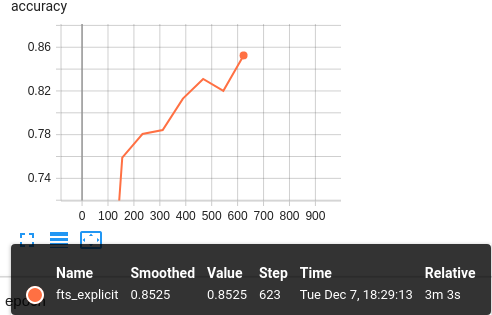{height="315px" width="492px"}](https://tensorboard.dev/experiment/n7U8XhrzRbmvVzC4SQSpWw/#scalars&_smoothingWeight=0&runSelectionState=eyJmdHNfZXhwbGljaXQiOnRydWUsIm5vZnRzX2Jhc2VsaW5lIjpmYWxzZSwiZnRzX2ltcGxpY2l0IjpmYWxzZX0%3D)
[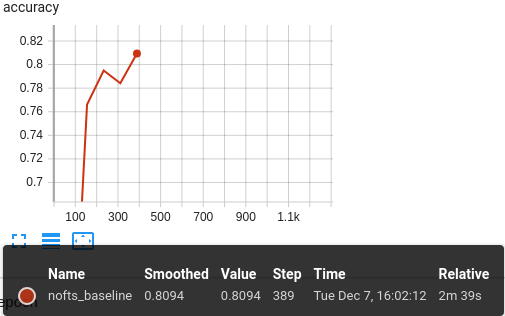{height="316px" width="505px"}](https://tensorboard.dev/experiment/n7U8XhrzRbmvVzC4SQSpWw/#scalars&_smoothingWeight=0&runSelectionState=eyJmdHNfZXhwbGljaXQiOmZhbHNlLCJub2Z0c19iYXNlbGluZSI6dHJ1ZSwiZnRzX2ltcGxpY2l0IjpmYWxzZX0%3D)

Note that given execution context differences, there could be a modest variation in performance from the tensorboard summaries generated by this notebook.

[FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) expands the space of possible fine-tuning schedules and the composition of more sophisticated schedules can
yield marginal fine-tuning performance gains. That stated, it should be emphasized the primary utility of [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) is to grant
greater fine-tuning flexibility for model exploration in research. For example, glancing at DeBERTa-v3's implicit training
run, a critical tuning transition point is immediately apparent:

[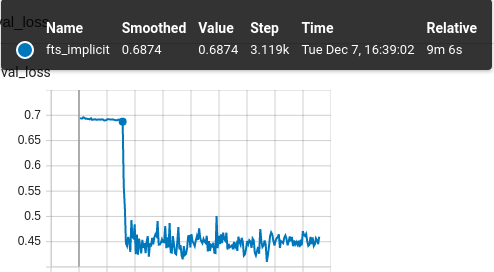{height="272px" width="494px"}](https://tensorboard.dev/experiment/n7U8XhrzRbmvVzC4SQSpWw/#scalars&_smoothingWeight=0&runSelectionState=eyJmdHNfZXhwbGljaXQiOmZhbHNlLCJub2Z0c19iYXNlbGluZSI6ZmFsc2UsImZ0c19pbXBsaWNpdCI6dHJ1ZX0%3D)

Our `val_loss` begins a precipitous decline at step 3119 which corresponds to phase 17 in the schedule. Referring to our
schedule, in phase 17 we're beginning tuning the attention parameters of our 10th encoder layer (of 11). Interesting!
Though beyond the scope of this tutorial, it might be worth investigating these dynamics further and
[FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) allows one to do just that quite easily.



Note that though this example is intended to capture a common usage scenario, substantial variation is expected
among use cases and models.
In summary, [FinetuningScheduler](https://finetuning-scheduler.readthedocs.io/en/stable/api/finetuning_scheduler.fts.html#finetuning_scheduler.fts.FinetuningScheduler) provides increased fine-tuning flexibility that can be useful in a variety of
contexts from exploring model tuning behavior to maximizing performance.

## Footnotes

<ol>
<li id="f1">

[Howard, J., & Ruder, S. (2018)](https://arxiv.org/pdf/1801.06146.pdf). Fine-tuned Language
 Models for Text Classification. ArXiv, abs/1801.06146. [↩](#a1)

 </li>
<li>

[Chronopoulou, A., Baziotis, C., & Potamianos, A. (2019)](https://arxiv.org/pdf/1902.10547.pdf).
 An embarrassingly simple approach for transfer learning from pretrained language models. arXiv
 preprint arXiv:1902.10547. [↩](#a1)

 </li>
<li>

[Peters, M. E., Ruder, S., & Smith, N. A. (2019)](https://arxiv.org/pdf/1903.05987.pdf). To tune or not to
 tune? adapting pretrained representations to diverse tasks. arXiv preprint arXiv:1903.05987. [↩](#a1)

</li>
<li id="f2">

[Sivaprasad, P. T., Mai, F., Vogels, T., Jaggi, M., & Fleuret, F. (2020)](https://arxiv.org/pdf/1910.11758.pdf).
 Optimizer benchmarking needs to account for hyperparameter tuning. In International Conference on Machine Learning
(pp. 9036-9045). PMLR. [↩](#a2)

</li>
<li id="f3">

[Mosbach, M., Andriushchenko, M., & Klakow, D. (2020)](https://arxiv.org/pdf/2006.04884.pdf). On the stability of
fine-tuning bert: Misconceptions, explanations, and strong baselines. arXiv preprint arXiv:2006.04884. [↩](#a2)

</li>
<li id="f4">

[Loshchilov, I., & Hutter, F. (2016)](https://arxiv.org/pdf/1608.03983.pdf). Sgdr: Stochastic gradient descent with
warm restarts. arXiv preprint arXiv:1608.03983. [↩](#a3)

</li>

</ol>

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)